# 测试学好的Q函数是否能表现得很好

实现目标：

1. 创建Agent， 并加载学习好的Q_net
2. 创建测试数据，使其可以分别输入IMM和Agent

In [1]:
from Agent import Agent
from Env import env

## 1. 加载Agent 

In [2]:
agent = Agent(test=True)
agent.load_Q_net("Q_net.model")

## 2.  数据生成

测试数据与训练数据同分布

In [3]:
from torch_geometric.data import Data
import torch
import numpy as np
import networkx as nx

## 3. Simulation 

In [4]:
def simulation_once(edge_index, edge_w, seed_list):
    import networkx as nx
    import ndlib.models.ModelConfig as mc
    import ndlib.models.epidemics as ep
    
    G = nx.DiGraph()
    G.add_edges_from(edge_index.T)
    
    model = ep.IndependentCascadesModel(G)
    
    # Model Configuration
    config = mc.Configuration()
    config.add_model_initial_configuration("Infected", seed_list)
    
    # Setting the edge parameters
    for e, w in zip(G.edges(), edge_w):
        config.add_edge_configuration("threshold", e, w)
    
    model.set_initial_status(config)
    
    while True:
        iteration = model.iteration()
        if iteration["node_count"][1] == 0:
            break
    
    return iteration["node_count"][2]

In [5]:
def simulation(edge_index, edge_w, seed_list, mc=100):
    from tqdm import tqdm
    import numpy as np
    from multiprocessing import Pool
    
    pool = Pool(50)
    spreads = []
    res = []
    for i in range(mc):
        res.append(pool.apply_async(simulation_once, (edge_index, edge_w, seed_list, )))
    
    pool.close()
    pool.join()
    
    for r in tqdm(res):
        spreads.append(r.get())
    return np.mean(spreads)

## 3. 方法比较 

In [6]:
def Q_infer(agent, graph, K):
    Seed = []
    for i in range(K):
        action = agent.choose_action(graph)
        Seed.append(action)
        graph.x[action] = 1
        
    return Seed

In [7]:
def before_IMM(edge_index, edge_w):
    import os
    import time
    G = nx.DiGraph()
    G.add_edges_from(edge_index.T)
    with open(".imm_cache/attribute.txt", "w") as f:
        f.writelines("n={}\nm={}".format(G.number_of_nodes(), G.number_of_edges()))
    with open(".imm_cache/graph_ic.inf", "w") as f:
        for edge, weight in zip(edge_index.T, edge_w):
            f.writelines("{} {} {:.3f}\n".format(edge[0], edge[1], weight[0]))

In [8]:
def IMM_infer(K):
    imm_red = os.popen("./IMM/imm_discrete -dataset .imm_cache/ -k {} -model IC -epsilon 0.1".format(K))
    
    Seed = []
    Spread = 0
    for line in imm_red:
        if "opt_lower_bound" in line:
            Spread = float(line.split("=")[1].strip())
        if "seedSet" in line:
            seed_set = line.split("=")[1].strip().split(" ")
            Seed = [int(s) for s in seed_set]
    
    return Seed, Spread

### 测试1， 相同大小的网络

In [9]:
import matplotlib.pyplot as plt

In [10]:
# ER graph
Env = env(graph_size=1000, seed_size=10, edge_weight=0.15, random_edge_weight=True)

edge_index, edge_weight, x, _ = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             edge_weight = torch.Tensor(edge_weight),
             x = torch.Tensor(x))

In [11]:
IMM_K = []
Q_K = []
K_range = [1, 100, 200, 300]
before_IMM(edge_index, edge_weight)

for K in K_range:
    imm_seed, imm_spread = IMM_infer(K=K)
    q_seed = Q_infer(agent, graph, K=K)

    imm_simu = simulation(edge_index, edge_weight, imm_seed, mc=500)
    q_simu = simulation(edge_index, edge_weight, q_seed, mc=500)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    

plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.show()

NameError: name 'os' is not defined

# 在真实的数据上测试 

In [121]:
def load_data(path):
    edge_index = []
    edge_weight = []
    n = m = 0
    with open(path, "r") as f:
        for line in f:
            line_list = line.strip().split(" ")
            if len(line_list) == 2:
                n, m = [int(x) for x in line_list]
            else:
                edge_index.append([int(x) for x in line_list[:2]])
                edge_weight.append([float(line_list[-1])])
    return n, m, np.array(edge_index).T, np.array(edge_weight)

In [122]:
n, m, edge_index, edge_weight = load_data("./data/Twitter.txt")

In [123]:
twitter = Data(edge_index = torch.LongTensor(edge_index),
               edge_weight = torch.Tensor(edge_weight),
               x = torch.zeros((n,1)))

100%|██████████| 50/50 [00:00<00:00, 129935.07it/s]


17485.56 7693.88


100%|██████████| 50/50 [00:00<00:00, 127023.14it/s]


18032.7 17535.92


100%|██████████| 50/50 [00:00<00:00, 136355.79it/s]


18744.84 17564.76


100%|██████████| 50/50 [00:00<00:00, 94211.68it/s]

19440.66 17515.06


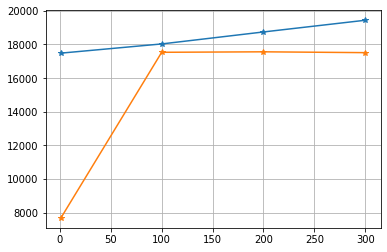

In [124]:
IMM_K = []
Q_K = []
K_range = [1, 100, 200, 300]
before_IMM(edge_index, edge_weight)

for K in K_range:
    imm_seed, imm_spread = IMM_infer(K=K)
    q_seed = Q_infer(agent, twitter, K=K)

    imm_simu = simulation(edge_index, edge_weight, imm_seed, mc=50)
    q_simu = simulation(edge_index, edge_weight, q_seed, mc=50)
    print(imm_simu, q_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    

plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.grid(True)
plt.show()

In [133]:
simulation(edge_index, edge_weight, imm_seed, mc=50)

100%|██████████| 50/50 [00:00<00:00, 128109.47it/s]


17625.8

In [134]:
simulation(edge_index, edge_weight, q_seed, mc=50)

100%|██████████| 50/50 [00:00<00:00, 155000.15it/s]


17571.24

In [129]:
imm_seed, imm_spread = IMM_infer(K=10)

In [130]:
q_seed = Q_infer(agent, twitter, K=10)

In [131]:
imm_seed

[2969, 1328, 1550, 663, 24446, 17488, 3687, 5242, 1327, 123]

In [132]:
q_seed

[113, 2593, 5031, 7446, 32945, 46272, 845, 9987, 1903, 6232]

In [126]:
Q_K

[([63], 7693.88),
 ([548,
   90,
   78,
   1,
   880,
   1739,
   603,
   437,
   436,
   3702,
   1758,
   7508,
   326,
   447,
   8785,
   683,
   56,
   30,
   2599,
   5026,
   5,
   554,
   1328,
   101,
   1422,
   3644,
   3582,
   3642,
   9,
   2969,
   87,
   572,
   1751,
   5000,
   1550,
   1752,
   151,
   2630,
   8787,
   2787,
   900,
   1335,
   1214,
   448,
   4189,
   42,
   1303,
   133,
   2604,
   2591,
   1423,
   9348,
   4366,
   1142,
   1807,
   1327,
   2700,
   6198,
   2651,
   896,
   1131,
   10010,
   1151,
   2678,
   3687,
   579,
   1733,
   2588,
   3121,
   7422,
   3710,
   9672,
   9690,
   3665,
   3697,
   3704,
   938,
   2623,
   1325,
   9673,
   1449,
   7872,
   6177,
   320,
   3711,
   1154,
   5016,
   510,
   1772,
   10,
   40,
   106,
   19682,
   4428,
   139,
   36,
   4484,
   21672,
   322,
   2674],
  17535.92),
 ([14260,
   15665,
   719,
   1740,
   378,
   580,
   499,
   1334,
   23,
   24349,
   3886,
   81,
   94,
   15

In [105]:
before_IMM(edge_index, edge_weight)

In [112]:
%%time
imm_seed, imm_spread = IMM_infer(K=10)
print(imm_seed)

[2969, 1328, 1550, 663, 24446, 17488, 3687, 5242, 1327, 123]
CPU times: user 2.23 ms, sys: 82.2 ms, total: 84.4 ms
Wall time: 4.81 s


In [113]:
%%time
q_seed = Q_infer(agent, twitter, K=10)
print(q_seed)

[326, 447, 8785, 683, 56, 30, 2599, 5026, 5, 554]
CPU times: user 4.62 s, sys: 312 ms, total: 4.94 s
Wall time: 1.64 s
